In [150]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import linregress
from merge_data import merge_data


In [151]:
def label_regions(df):  
    regions = {'North America':["Canada","Mexico","US", "United States", "United States of America"],
           'South/Central America':["Argentina","Brazil","Chile","Colombia","Ecuador","Peru","Trinidad & Tobago",
                         "Venezuela","Central America","Other Caribbean","Other South America"],
           'Europe':["Austria","Belgium","Bulgaria","Croatia","Cyprus","Czech Republic","Denmark",
                         "Estonia","Finland","France","Germany","Greece","Hungary","Iceland","Ireland","Italy",
                         "Latvia","Lithuania","Luxembourg","Netherlands","North Macedonia","Norway","Poland",
                         "Portugal","Romania","Slovakia","Slovenia","Spain","Sweden","Switzerland","Turkey",
                         "Ukraine","United Kingdom","Other Europe"],
           'CIS':["Azerbaijan","Belarus","Kazakhstan","Russian Federation",
                         "Turkmenistan","USSR","Uzbekistan","Other CIS"],
           'Middle East':["Iran","Iraq","Israel","Kuwait","Oman","Qatar","Saudi Arabia","United Arab Emirates",
                         "Other Middle East"],
           'Africa':["Algeria","Egypt","Morocco","South Africa","Eastern Africa","Middle Africa",
                         "Western Africa","Other Northern Africa","Other Southern Africa"],
           'Asia Pacific':["Australia","Bangladesh","China","China Hong Kong SAR","India","Indonesia",
                          "Japan","Malaysia","New Zealand","Pakistan","Philippines","Singapore",
                          "South Korea","Sri Lanka","Taiwan","Thailand","Vietnam","Other Asia Pacific"]
                       }
    df['Region'] = ""
    for region, countries in regions.items():
        df.loc[df["Country"].isin(countries),"Region"]=region
    return df 

In [152]:
#import and clean the power data
power_file = 'data/global_power_plant_database.csv'
power_df = pd.read_csv(power_file)
power_df['commissioning_year'] = round(power_df['commissioning_year'],0)
power_df = power_df[power_df['commissioning_year']==2016]
cap_type = power_df[['country_long', 'capacity_mw', 'primary_fuel']]
cap_type = cap_type.rename(columns={'country_long':'Country'})
label_regions(cap_type)
cap_type[cap_type['Region']=='North America'].head()



,Country,capacity_mw,primary_fuel,Region
20909,United States of America,11.0,Storage,North America
20922,United States of America,1.3,Gas,North America
20923,United States of America,1.3,Gas,North America
20943,United States of America,154.3,Wind,North America
20949,United States of America,20.0,Solar,North America


In [153]:
renewables = ['Wind', 'Biomass', 'Geothermal', 'Solar']
nuclear = ['Waste', 'Storage']  # data fudging for unknown types (no nuclear types in power db)
cap_type['primary_fuel'].unique()

array(['Gas', 'Oil', 'Hydro', 'Biomass', 'Wind', 'Waste', 'Coal', 'Solar',
       'Storage', 'Cogeneration'], dtype=object)

In [161]:
g = cap_type.groupby('Region')

oil = g.apply(lambda x: x[x['primary_fuel']=='Oil']['capacity_mw'].sum() )
gas = g.apply(lambda x: x[x['primary_fuel']=='Gas']['capacity_mw'].sum() )
coal = g.apply(lambda x: x[x['primary_fuel']=='Coal']['capacity_mw'].sum() )
nuclear = g.apply(lambda x: x[x['primary_fuel'].isin(nuclear)]['capacity_mw'].sum() )
hydro = g.apply(lambda x: x[x['primary_fuel']=='Hydro']['capacity_mw'].sum() )
renewables = g.apply(lambda x: x[x['primary_fuel'].isin(renewables)]['capacity_mw'].sum() )

oil = oil.to_frame()
gas = gas.to_frame()
coal = coal.to_frame()
nuclear = nuclear.to_frame()
hydro = hydro.to_frame()
renewables = renewables.to_frame()

oil = oil.rename(columns = {0:"Oil"})
gas = gas.rename(columns = {0:"Natural Gas"})
coal = coal.rename(columns = {0:"Coal"})
nuclear = nuclear.rename(columns = {0:"Nuclear Energy"})
hydro = hydro.rename(columns = {0:"Hydro"})
renewables = renewables.rename(columns = {0:"Renewables"})

m1 = pd.merge(oil, gas, on="Region", how="outer")
m2 = pd.merge(m1, coal, on="Region", how="outer")
m3 = pd.merge(m2, nuclear, on="Region", how="outer")
m4 = pd.merge(m3, hydro, on="Region", how="outer")
green_cap_df = pd.merge(m4, renewables, on="Region", how="outer")
green_cap_df = green_cap_df[1:len(green_cap_df)]  # remove unidentified regions
green_cap_df.head(10)

,Oil,Natural Gas,Coal,Nuclear Energy,Hydro,Renewables
Region,,,,,,
Africa,0.0000,1500.0,0.0,0.0,0.00000,0.0
Asia Pacific,55.5000,1678.0,61313.7,0.0,11592.60000,0.0
Europe,0.0000,0.0,1850.0,0.0,1000.00000,0.0
Middle East,10116.8100,7478.2,0.0,0.0,0.00000,0.0
North America,50.7000,7470.5,0.0,0.0,259.50000,0.0
South/Central America,189.7316,518.8,164.0,0.0,3828.57294,0.0


In [117]:
#import and format generation per capita data
generation_file = 'data/generation.csv'
gen_df = pd.read_csv(generation_file)
gen_df = gen_df.dropna()
gen_df=gen_df.rename(columns = {'Year':'Year', 'US':'US', 'Total So/Cent America':'South/Cent America', 
                                'Total Europe':'Europe', 'Total CIS':'CIS', 
                                'Total Middle East':'Middle East', 'Total Africa':'Africa', 
                                'Total Asia Pacific':'Asia Pacific', 'Total World':'World'})
gen_df.head()

,Year,Total North America,Total S. & Cent. America,Europe,CIS,Middle East,Africa,Asia Pacific,World
0,1965,220.4,22.1,93.0,107.8,35.0,7.9,10.4,46.4
1,1966,229.5,22.8,94.9,113.3,35.5,8.1,11.1,48.0
2,1967,234.4,23.2,97.0,117.9,36.1,8.0,11.4,48.8
3,1968,245.5,24.0,102.6,121.0,37.0,8.2,11.9,50.7
4,1969,255.4,24.6,109.3,125.3,37.8,8.2,13.2,53.0


In [114]:
#import and format green data
green_file = 'data/green.csv'
green_df = pd.read_csv(green_file)
#green_df.set_index('Region')
green_df = green_df.drop(['Change 2018', '1990-2018','Change Oil',
 'Change Natural Gas',
 'Change Coal',
 'Change Nuclear energy',
 'Change Hydro electric',
 'Change Renewables'], axis=1)
list(green_df)
#df.drop(['Cochice', 'Pima'])
#green_df.drop(green_df.index[7])
green_df = green_df[green_df.Region != "Total World"]
green_df=green_df.rename(columns = {'Region':'Region','2018 Oil':'Oil','2018 Natural Gas':'Natural Gas',
                                '2018 Coal':'Coal','2018 Nuclear energy':'Nuclear Energy',
                                '2018 Hydro electric':'Hydro','2018 Renewables':'Renewables'})
green_df

,Region,Oil,Natural Gas,Coal,Nuclear Energy,Hydro,Renewables
0,Total North America,1113,879,343,218,160,119
1,Total So/Cent America,315,145,36,5,165,35
2,Total Europe,742,472,307,212,145,172
3,Total CIS,194,499,135,47,55,1
4,Total Middle East,412,476,8,2,3,2
5,Total Africa,191,129,101,3,30,7
6,Total Asia Pacific,1695,710,2841,125,389,225


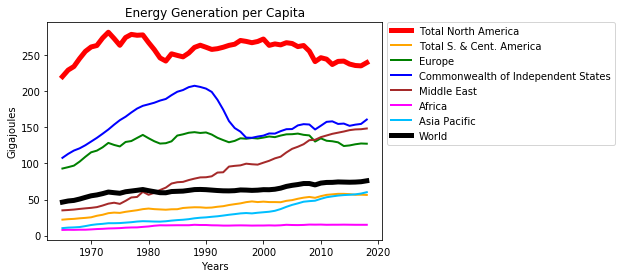

In [119]:
plt.plot(gen_df["Year"],gen_df["Total North America"],color="red",linewidth=5,label="Total North America")
plt.plot(gen_df["Year"],gen_df["Total S. & Cent. America"],color="orange",linewidth=2,label="Total S. & Cent. America")
plt.plot(gen_df["Year"],gen_df["Europe"],color="green",linewidth=2,label="Europe")
plt.plot(gen_df["Year"],gen_df["CIS"],color="blue",linewidth=2,label="Commonwealth of Independent States")
plt.plot(gen_df["Year"],gen_df["Middle East"],color="brown",linewidth=2,label="Middle East")
plt.plot(gen_df["Year"],gen_df["Africa"],color="fuchsia",linewidth=2,label ="Africa")
plt.plot(gen_df["Year"],gen_df["Asia Pacific"],color="deepskyblue",linewidth=2,label="Asia Pacific")
plt.plot(gen_df["Year"],gen_df["World"],color="black",linewidth=5,label="World")
plt.title("Energy Generation per Capita")
plt.xlabel("Years")
plt.ylabel("Gigajoules")
plt.legend(bbox_to_anchor=(1, 1.025))
plt.tight_layout
plt.savefig("Regional Energy Gen Over Time.png")

In [120]:
# define function to plot the linear regression line

def plot_linear_reg(country, color):
    x = np.linspace(1990, 2017, 3)
    result = linregress(gen_df['Year'], gen_df[country])
    y = result[0]*x+result[1]
    plt.plot(x, y, color=color, label=country)
    

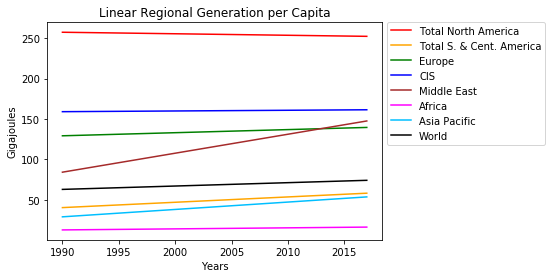

In [124]:
# graph and create png of linear regressions of Energy Generation By Region
plot_linear_reg('Total North America', 'red')
plot_linear_reg('Total S. & Cent. America', 'orange')
plot_linear_reg('Europe', 'green')
plot_linear_reg('CIS', 'blue')
plot_linear_reg('Middle East', 'brown')
plot_linear_reg('Africa', 'fuchsia')
plot_linear_reg('Asia Pacific', 'deepskyblue')
plot_linear_reg('World', 'black')

plt.title("Linear Regional Generation per Capita")
plt.xlabel("Years")
plt.ylabel("Gigajoules")
plt.legend(bbox_to_anchor=(1, 1.025))
plt.tight_layout
plt.savefig("Linear Regional Energy Gen Over Time.png")

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

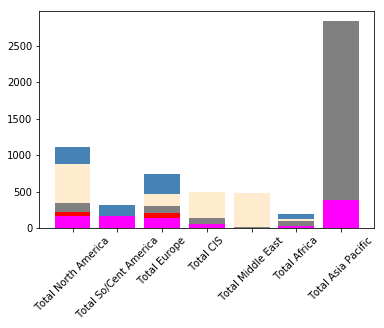

In [125]:
oil=green_df["Oil"]
gas=green_df["Natural Gas"]
coal=green_df["Coal"]
nuclear=green_df["Nuclear Energy"]
hydro=green_df["Hydro"]

plt.bar(green_df["Region"],oil,color="steelblue")
plt.bar(green_df["Region"],gas, color="blanchedalmond")
plt.bar(green_df["Region"],coal, color="gray")
plt.bar(green_df["Region"],nuclear,color="red")
plt.bar(green_df["Region"],hydro,color="fuchsia")

#green_df.pivot("Oil","Natural Gas","Coal").plot(kind='bar')

# plt.bar(green_df["Region"],oil,color="steelblue")
# plt.bar(green_df["Region"],gas,bottom=oil, color="blanchedalmond")
# plt.bar(green_df["Region"],coal,bottom=gas, color="gray")
# plt.bar(green_df["Region"],nuclear,bottom=coal,color="red")
# plt.bar(green_df["Region"],hydro,bottom=nuclear,color="fuchsia")

#plt.bar(green_d,color="rosybrodf["Region"],green_df["Natural Gas]",bottom=green_df["Oil"],color="rosybrown")
plt.xticks(rotation=45)

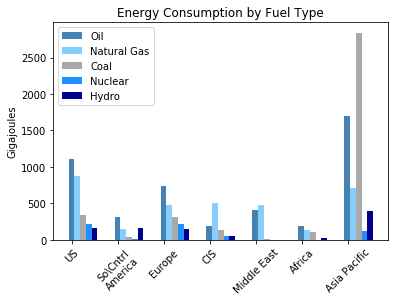

In [127]:
N = 7
# menMeans = (150*cm, 160*cm, 146*cm, 172*cm, 155*cm)
# menStd = (20*cm, 30*cm, 32*cm, 10*cm, 20*cm)

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.125         # the width of the bars
p1 = ax.bar(ind, oil, width, bottom=0,color="steelblue")
p2 = ax.bar(ind + width, gas, width, bottom=0,color="lightskyblue")
p3 = ax.bar(ind + width*2, coal, width, bottom=0,color="darkgray")
p4 = ax.bar(ind + width*3, nuclear, width, bottom=0,color="dodgerblue")
p5 = ax.bar(ind + width*4, hydro, width, bottom=0,color="darkblue")


ax.set_title('Energy Consumption by Fuel Type')
ax.set_xticks(ind + width / 10)
ax.set_xticklabels(('US', 'So\Cntrl\nAmerica', 'Europe', 'CIS', 'Middle East','Africa', 'Asia Pacific'),rotation=45)

ax.legend((p1[0], p2[0],p3[0], p4[0],p5[0]), ('Oil', 'Natural Gas','Coal','Nuclear','Hydro'))
ax.set_ylabel("Gigajoules")
#ax.yaxis.set_units("Gigajoules")
#ax.autoscale_view()

plt.show()

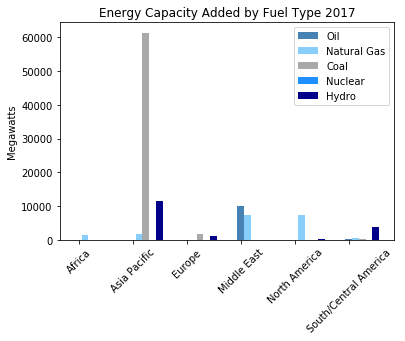

In [163]:
oil_cap = green_cap_df["Oil"]
gas_cap = green_cap_df["Natural Gas"]
coal_cap = green_cap_df["Coal"]
nuclear_cap = green_cap_df["Nuclear Energy"]
hydro_cap = green_cap_df["Hydro"]

N = 6
# menMeans = (150*cm, 160*cm, 146*cm, 172*cm, 155*cm)
# menStd = (20*cm, 30*cm, 32*cm, 10*cm, 20*cm)

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.125         # the width of the bars
p1 = ax.bar(ind, oil_cap, width, bottom=0,color="steelblue")
p2 = ax.bar(ind + width, gas_cap, width, bottom=0,color="lightskyblue")
p3 = ax.bar(ind + width*2, coal_cap, width, bottom=0,color="darkgray")
p4 = ax.bar(ind + width*3, nuclear_cap, width, bottom=0,color="dodgerblue")
p5 = ax.bar(ind + width*4, hydro_cap, width, bottom=0,color="darkblue")


ax.set_title('Energy Capacity Added by Fuel Type 2017')
ax.set_xticks(ind + width / 10)
ax.set_xticklabels(('Africa', 'Asia Pacific', 'Europe', 'Middle East', 'North America', 'South/Central America'),rotation=45)

ax.legend((p1[0], p2[0],p3[0], p4[0],p5[0]), ('Oil', 'Natural Gas','Coal','Nuclear','Hydro'))
ax.set_ylabel("Megawatts")
#ax.yaxis.set_units("Gigajoules")
#ax.autoscale_view()

plt.show()